In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
ratings_df = pd.read_csv('../data/jester_ratings.csv')
jokes_df = pd.read_csv('../data/jester_items.csv')
display(ratings_df[:5]), display(jokes_df[:5])

,userId,jokeId,rating
0,1,5,0.219
1,1,7,-9.281
2,1,8,-9.281
3,1,13,-6.781
4,1,15,0.875


,jokeId,jokeText
0,1,"A man visits the doctor. The doctor says ""I ha..."
1,2,This couple had an excellent relationship goin...
2,3,Q. What's 200 feet long and has 4 teeth? \r\n\...
3,4,Q. What's the difference between a man and a t...
4,5,Q.\tWhat's O. J. Simpson's Internet address? \...


(None, None)

In [3]:
physical_devices = torch.cuda.get_device_name(0)
# tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device 

NVIDIA GeForce RTX 3060 Laptop GPU


'cuda'

In [4]:
# only dataframe with user ids, joke ids and rating is needed
df = ratings_df 

In [5]:
# Encoding userId and jokeId
df['userId'] = df['userId'].astype('category').cat.codes.values
df['jokeId'] = df['jokeId'].astype('category').cat.codes.values

In [6]:
train_data, test_data = train_test_split(df, test_size=0.3)
train_data.shape, test_data.shape 

((1233007, 3), (528432, 3))

#### Neural Matrix Factorization Model 

![](neuralMF_architecture.JPG)

In [7]:
class NeuMF(nn.Module):
    def __init__(self, num_users, num_items, mf_dim, mlp_layers):
        super(NeuMF, self).__init__()
        self.mf_user_embedding = nn.Embedding(num_users, mf_dim)
        self.mf_item_embedding = nn.Embedding(num_items, mf_dim)

        self.mlp_user_embedding = nn.Embedding(num_users, mlp_layers[0] // 2)
        self.mlp_item_embedding = nn.Embedding(num_items, mlp_layers[0] // 2)

        mlp_modules = []
        input_size = mlp_layers[0]
        for hidden_units in mlp_layers[1:]:
            mlp_modules.append(nn.Linear(input_size, hidden_units))
            mlp_modules.append(nn.ReLU())
            input_size = hidden_units
        self.mlp_layers = nn.Sequential(*mlp_modules)

        self.final_layer = nn.Linear(mf_dim + mlp_layers[-1], 1)


    def forward(self, user, item):
        
        # GMF (Generalized Matrix Factorization) part
        mf_user_latent = self.mf_user_embedding(user)
        mf_item_latent = self.mf_item_embedding(item)
        mf_vector = mf_user_latent * mf_item_latent  # Element-wise product

        # MLP (Multi-Layer Perceptron) part
        mlp_user_latent = self.mlp_user_embedding(user)
        mlp_item_latent = self.mlp_item_embedding(item)
        mlp_vector = torch.cat([mlp_user_latent, mlp_item_latent], dim=-1)
        mlp_vector = self.mlp_layers(mlp_vector)

        # Concatenation of GMF and MLP parts
        neu_vector = torch.cat([mf_vector, mlp_vector], dim=-1)
        output = self.final_layer(neu_vector)

        return output.squeeze()

In [8]:
# Hyperparameters
# dimension for matrix factorization section
mf_dim = 50
mlp_layers = [256, 128, 64, 32]

num_users = df['userId'].nunique()
num_jokes = df['jokeId'].nunique()
num_users, num_jokes

(59132, 140)

In [9]:
model = NeuMF(num_users, num_jokes, mf_dim, mlp_layers)
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


model 

NeuMF(
  (mf_user_embedding): Embedding(59132, 50)
  (mf_item_embedding): Embedding(140, 50)
  (mlp_user_embedding): Embedding(59132, 128)
  (mlp_item_embedding): Embedding(140, 128)
  (mlp_layers): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
  )
  (final_layer): Linear(in_features=82, out_features=1, bias=True)
)

In [10]:
train_user_ids = torch.tensor(train_data['userId'].values, dtype=torch.long).to(device)
train_joke_ids = torch.tensor(train_data['jokeId'].values, dtype=torch.long).to(device)
train_ratings = torch.tensor(train_data['rating'].values, dtype=torch.float32).to(device)

In [11]:
train_dataset = torch.utils.data.TensorDataset(train_user_ids, train_joke_ids, train_ratings)
batch_size = 64 
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
len(train_dataset)

1233007

In [12]:
# Training loop

training_losses = []
iter_losses = []

def train_model(model, epochs=5, batch_size=64):
    model.train()
    
    for epoch in range(epochs):
        total_loss = 0
        for user_ids, joke_ids, ratings in train_loader:
            optimizer.zero_grad()
            predictions = model(user_ids, joke_ids)
            loss = criterion(predictions, ratings)
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.detach().cpu().numpy()
            
            iter_losses.append(total_loss)
            
        avg_loss = total_loss / len(train_loader)
        training_losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss}")

In [13]:
train_model(model, epochs=1)

Epoch 1/1, Loss: 20.9915321395737


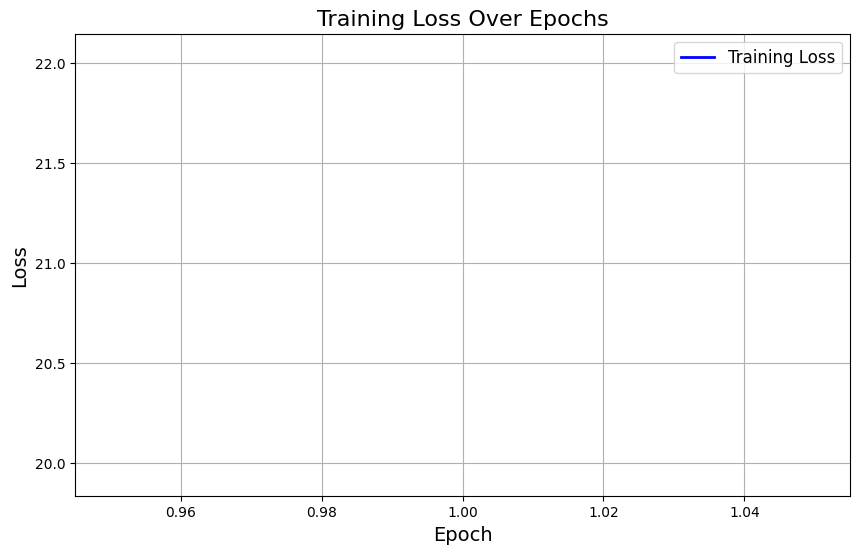

In [14]:
import matplotlib.pyplot as plt 

def plot_losses(losses):
    plt.figure(figsize=(10, 6))
    
    plt.plot(range(1, len(losses) + 1), losses, label='Training Loss', color='b', linewidth=2)

    plt.title('Training Loss Over Epochs', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)

    plt.grid(True)
    plt.legend(loc='upper right', fontsize=12)

    plt.show()

plot_losses(training_losses)

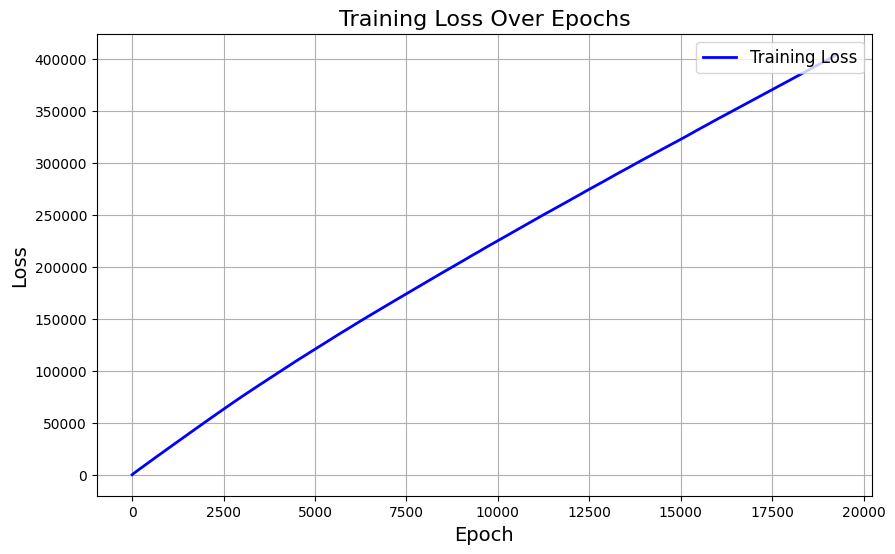

In [15]:
plot_losses(iter_losses)

## Evaluation of model with metrics

In [29]:
from sklearn.metrics import precision_score, recall_score
from scipy.special import expit as sigmoid
import numpy as np

In [55]:
def compute_ndcg(predictions, true_labels, k=2):
    if k>predictions.shape[0]:
        k = len(predictions)
    relevance = np.array([true_labels[i] for i in np.argsort(-predictions)[:k]])
    dcg = np.sum((2**relevance - 1) / np.log2(np.arange(2, k + 2)))
    
    # Compute IDCG using sorted relevance
    sorted_relevance = np.sort(true_labels)[::-1]
    idcg_relevance = np.array([sorted_relevance[i] for i in np.argsort(-predictions)[:k]])
    idcg = np.sum((2**idcg_relevance - 1) / np.log2(np.arange(2, k + 2)))
    
    return dcg / idcg if idcg > 0 else 0

In [56]:
compute_ndcg(np.array([1,2,3,4]), np.array([3,3,2,3])) 

1.199053372688933

In [69]:
def evaluate_model2(model, test_data, k=10):
    model.eval()
    test_user_ids = torch.tensor(test_data['userId'].values, dtype=torch.long).to(device)
    test_item_ids = torch.tensor(test_data['jokeId'].values, dtype=torch.long).to(device)
    test_ratings = torch.tensor(test_data['rating'].values, dtype=torch.float).to(device)
    with torch.no_grad():
        predictions = model(test_user_ids, test_item_ids).detach().cpu().numpy()

    mse = ((predictions - test_data['rating'].values) ** 2).mean()
    print(f"Test MSE: {mse}")

    # Convert to binary relevance for precision/recall calculations
    binary_relevance = (test_ratings.cpu().numpy() > 0).astype(int)
    predicted_scores = torch.sigmoid(torch.tensor(predictions)).numpy()

    # Prepare for batch processing
    unique_user_ids = np.unique(test_user_ids.cpu().numpy())
    precision_at_k = []
    recall_at_k = []
    ndcg_at_k = []

    # Convert to torch tensors for efficiency
    user_scores_tensor = torch.tensor(predicted_scores)
    user_labels_tensor = torch.tensor(binary_relevance)

    for user_id in unique_user_ids:
        user_indices = np.where(test_user_ids.cpu().numpy() == user_id)[0]
        user_scores = user_scores_tensor[user_indices].numpy()
        user_labels = user_labels_tensor[user_indices].numpy()

        # Sort items for the user by predicted scores
        sorted_indices = np.argsort(-user_scores)
        top_k_indices = sorted_indices[:k]
        
        # Precision and Recall @k
        relevant_items = np.sum(user_labels[top_k_indices])
        precision_at_k.append(relevant_items / k)
        recall_at_k.append(relevant_items / np.sum(user_labels))

        # NDCG @k
        ndcg_at_k.append(compute_ndcg(user_scores, user_labels, k))

    print(f"Precision @ {k}: {np.mean(precision_at_k)}")
    print(f"Recall @ {k}: {np.mean(recall_at_k)}")
    print(f"NDCG @ {k}: {np.mean(ndcg_at_k)}")

In [70]:
def evaluate_model(model, test_data):
    model.eval()
    test_user_ids = torch.tensor(test_data['userId'].values, dtype=torch.long).to(device)
    test_item_ids = torch.tensor(test_data['jokeId'].values, dtype=torch.long).to(device)
    test_ratings = test_data['rating'].values
    with torch.no_grad():
        predictions = model(test_user_ids, test_item_ids).detach().cpu().numpy()
    mse = ((predictions - test_ratings) ** 2).mean()
    print(f"Test MSE: {mse}")

In [71]:
# Evaluate the model
evaluate_model(model, test_data)

Test MSE: 19.006006816375184


In [72]:
evaluate_model2(model, test_data)

Test MSE: 19.006006816375184


C:\Users\OMEN\AppData\Local\Temp\ipykernel_19804\2578862550.py:38: RuntimeWarning: invalid value encountered in scalar divide
  recall_at_k.append(relevant_items / np.sum(user_labels))


Precision @ 10: 0.40299353912419245
Recall @ 10: nan
NDCG @ 10: 0.9837646577846402


In [18]:
def predict_rating(model, user_id, joke_id):
    model.eval()  
    with torch.no_grad():
        user_tensor = torch.tensor([user_id], dtype=torch.long).to(device)
        joke_tensor = torch.tensor([joke_id], dtype=torch.long).to(device)
        prediction = model(user_tensor, joke_tensor)
    return prediction.item() 

In [19]:
num_jokes 

140

In [20]:
user_id = 10  
joke_id = 1  

predicted_rating = predict_rating(model, user_id, joke_id)
predicted_rating 

-1.5555334091186523